## Splitting Reviews to Sentences

### Import Libraries

In [74]:
import pandas as pd
import numpy as np
from time import time

pd.set_option('display.max_colwidth', -1)

import spacy
import textblob

# For reading from Postgres
from sqlalchemy import create_engine

# For pickling
import pickle

# For tracking progress
from IPython.display import clear_output

# For reading and writing to postgres
from odo import odo

# For detecting language of document
from langdetect import detect
from langdetect import DetectorFactory 

# for consistent results
DetectorFactory.seed = 42 

import nltk

# The NLP workhorse in Python is Natural Language Toolkit (NLTK)
# Tokenizing, lemmatizing
from nltk import word_tokenize, pos_tag, ne_chunk

# Preprocessing packages used in class
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


# For loading secret environment variables, e.g. postgres username and password
import os
from dotenv import load_dotenv, find_dotenv


### Load Environment Variables

In [2]:
# Find .env
dotenv_path = find_dotenv()

# Load entries as environment variables
load_dotenv(dotenv_path)

public_ip = os.environ.get("PUBLIC_IP")
username = os.environ.get("USERNAME")
password = os.environ.get("PASSWORD")
port = os.environ.get("PORT")

# Construct database URL from environment variables
uri = f'postgresql://{username}:{password}@{public_ip}:{port}'

### Load Data from Postgres

#### All Mon Ami Gabi Reviews

In [3]:
t0 = time()
mon_ami_gabi = odo(uri+'::mon_ami_gabi_reviews', pd.DataFrame)
t1 = np.round(time() - t0,2)

print(f'Loaded {mon_ami_gabi.shape[0]} rows in {t1} seconds')

Loaded 7968 rows in 2.14 seconds


In [2]:
mon_ami_gabi.head()

NameError: name 'mon_ami_gabi' is not defined

#### Onion Soup reviews

In [4]:
# Connection to Postgres database
engine = create_engine(uri)

In [5]:
SQL = '''
SELECT mag.*
FROM mon_ami_gabi_reviews AS mag 
WHERE mag.text ~* 'onion soup' OR mag.text ~* 'french onion'
'''
onion_soup = pd.read_sql(SQL, con = engine)

### Load data locally

In [3]:
onion_soup_reviews = pd.read_csv('../data/interim/onion_soup_reviews.csv')

eggs_benedict_reviews = pd.read_csv('../data/interim/eggs_benedict_reviews.csv')

In [58]:
menu = pickle.load( open( "../data/interim/menu.pk", "rb" ) )

### Drop rows that are not English

In [4]:
def get_english_reviews(df):
    language = df['text'].apply(detect)
                  
    return df.drop(df[language != 'en'].index, axis = 0)
    

In [5]:
t0 = time()
onion_soup_reviews = get_english_reviews(onion_soup_reviews)
t1 = time() - t0
print(t1)

5.136317014694214


In [6]:
t0 = time()
eggs_benedict_reviews = get_english_reviews(eggs_benedict_reviews)
t1 = time() - t0
print(t1)

3.33713698387146


### Tokenize & Lemmatize Data

[Penn Part of Speech Tags](https://cs.nyu.edu/grishman/jet/guide/PennPOS.html)

In [228]:
def preprocess2(sentence):
    # Tokenize doc
    tokens = word_tokenize(sentence)
    
    # Tag sentences
    tagged_tokens = pos_tag(tokens)

    # Named entity chunker
    ne_chunked_tokens = ne_chunk(tagged_tokens, binary = True)
#     return ne_chunked_tokens
    # Extract all named entities
    named_entities = []
    
    for tagged_tree in ne_chunked_tokens:
        print(tagged_tree)
        if hasattr(tagged_tree, 'label'):
            entity_name = ' '.join(c[0] for c in tagged_tree.leaves())
            entity_type = tagged_tree.label() # category
            named_entities.append((entity_name, entity_type))
    
    return named_entities
    

In [229]:
processed_onion_soup = preprocess2(onion_soup['sentences'][1][0])

(NE French/JJ)
('onion', 'NN')
('soup', 'NN')
('was', 'VBD')
('watery', 'JJ')
('with', 'IN')
('little', 'JJ')
('taste', 'NN')


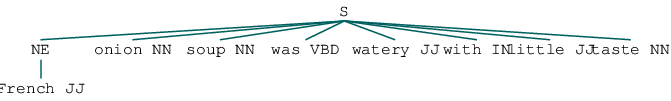

In [197]:
processed_onion_soup

In [7]:
onion_soup_reviews.head()

,text,cool,funny,review_id,date,stars,business_id,useful,user_id,business_name
0,"Other than being right across the Fountains of Bellagio, I'm not quite sure what the hype is abo...",1.0,2.0,uczUlWIWuO-KzoUiLhICNw,2015-02-10,2.0,4JNXUYY8wbaaDmk3BPzlWw,3.0,9zuYkm3k4_9KjE1PC8EPfg,Mon Ami Gabi
1,French onion soup was watery with little taste. We sent it back and were refunded the cost. Th...,0.0,0.0,185E0cpQpDRUO4JRGu3fXQ,2017-04-24,3.0,4JNXUYY8wbaaDmk3BPzlWw,0.0,EYiYLS0ZHDKGJSb1IKcpwg,Mon Ami Gabi
2,Where to begin! Now our dining experience here was not a common one - we were treated to dinner...,0.0,0.0,QoY3L_d_axTcMn68pI8zxQ,2014-12-03,5.0,4JNXUYY8wbaaDmk3BPzlWw,1.0,mp3Xy-w2isyLjEN91xOeGQ,Mon Ami Gabi
3,Charming resturant that looks like it would be heavily overpriced. Been here twice now and reall...,0.0,0.0,nth_q-GqOy_Ly8sxsREIwA,2010-12-04,4.0,4JNXUYY8wbaaDmk3BPzlWw,0.0,M4g64KUEia1qgcn-qNlYsw,Mon Ami Gabi
4,"This review is long overdue! I have been eating here for years, it is always on my ""must have""...",0.0,0.0,l0Lm7Dx69s6aH7a-5dwKDg,2010-07-11,5.0,4JNXUYY8wbaaDmk3BPzlWw,0.0,pQAUyBorkc1ZOxmV-uJ02w,Mon Ami Gabi


### Separate each review document into individual sentences

In [8]:
def flatten(superlist): 
    '''
    Arguments: 
    superlist : A list of list of strings.

    Requirements: 
    Each element in superlist must be a list.
    
    Return:
    A flattened list of strings.

    ex: 
    flatten([['a'], ['b', 'c'], ['d', 'e', 'f']])
    >> ['a', 'b', 'c', 'd', 'e', 'f']
    '''    
    return [item \
            for sublist in superlist \
            for item in sublist]

In [99]:
def get_sentences(doc, menu):
    '''
    Arguments: 
    doc : Dataframe of reviews
    term : String to search sentences that mention the term
    
    Splits a string into individual sentences and
    selects only the sentences that contain the search term
    
    Return:
    DataFrame of sentences with their target
    '''
    sentences = doc.apply(lambda text : text.split('.'))
#     df['sentences'] = df['sentences'].apply(lambda sentences : [s for s in sentences])
    sentences = flatten(sentences)
    sentences_tags = []
    
    n_sentences = len(sentences)
    
    for i,s in enumerate(sentences):
        s = s.lower()
        clear_output(wait = True)
        print(f'Finding tags in {i+1}/{n_sentences}')
        
        tags = []
        for i,row in menu.iterrows():
            for variation in row['variations']:
                if variation in s:
                    # print(row['entity'], '\t', variation)
                    tags.append(row['entity'])
                    break
        sentences_tags.append(', '.join(tags))
    
    
    return pd.DataFrame(list(zip(sentences, sentences_tags)), columns = ['text', 'tags'])
#     return pd.DataFrame([{'text' : s, 'target' : term} for s in sentences])    
    

In [80]:
onion_soup_sentences = get_sentences(onion_soup_reviews['text'], menu)

Finding tags in 10720/10720


In [82]:
onion_soup_sentences.head()

,text,tags
0,"Other than being right across the Fountains of Bellagio, I'm not quite sure what the hype is about this place",
1,"We came here for brunch during peak hour, but luckily had a reservation so ended up waiting only a few minutes",
2,"Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicken and Mushroom Crepe (with kale and brie); Seafood Crepe (with scallops, shrimp, peas and cream); Onion soup; and Eggs Benedict (with Canadian bacon and hollandaise sauce)","scallops_gratinees, onion_soup_au_gratin, bordelaise, prime_steak_frites, frites, classic_eggs_benedict, chicken_and_mushroom_crepe, seafood_crepe"
3,The steak frites and onion soup were the best things we ordered,"onion_soup_au_gratin, prime_steak_frites, frites"
4,"Steak frites came with a huge chunk of juicy steak and a side of crispy, salted fries","prime_steak_frites, frites"


In [85]:
onion_soup_sentences = onion_soup_sentences[onion_soup_sentences['tags'].str.contains('onion_soup_au_gratin')]
onion_soup_sentences.shape


(1007, 2)

In [87]:
onion_soup_sentences.head()

,text,tags
2,"Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicken and Mushroom Crepe (with kale and brie); Seafood Crepe (with scallops, shrimp, peas and cream); Onion soup; and Eggs Benedict (with Canadian bacon and hollandaise sauce)","scallops_gratinees, onion_soup_au_gratin, bordelaise, prime_steak_frites, frites, classic_eggs_benedict, chicken_and_mushroom_crepe, seafood_crepe"
3,The steak frites and onion soup were the best things we ordered,"onion_soup_au_gratin, prime_steak_frites, frites"
5,"Onion soup was also a nice, big portion, but I can't say it stood out from other onion soups I've had",onion_soup_au_gratin
12,French onion soup was watery with little taste,onion_soup_au_gratin
20,"We ate almost everything on the menu - although their French Onion Soup wasn't spectacular, their baked goat cheese, fresh French bread and steaks were to die for","baked_goat_cheese, onion_soup_au_gratin"


In [91]:
eggs_benedict_sentences = get_sentences(eggs_benedict_reviews['text'], menu)

Finding tags in 6464/6464


In [94]:
eggs_benedict_sentences.head()

,text,tags
0,"I booked a table here for brunch and it did not disappoint, it was a great experience and more relaxed I feel that the pricy dinner menu would of been, with the same outdoor table overlooking the Bellagio fountains and the Paris hotel",
1,Eggs Benedict for me was fab and some other good options on the menu,classic_eggs_benedict
2,I told them we were celebrating a birthday and got a chocolate cake with a candle brought out which I was pleased to find was not included on our bill at the end!,
3,Great breakfast,
4,Good mimosas and bloody marys,


In [95]:
eggs_benedict_sentences = eggs_benedict_sentences[eggs_benedict_sentences['tags'].str.contains('eggs_benedict')]
eggs_benedict_sentences.shape


(546, 2)

In [96]:
eggs_benedict_sentences.head()

,text,tags
1,Eggs Benedict for me was fab and some other good options on the menu,classic_eggs_benedict
5,The French toast and eggs Benedict with duck was delicious,"classic_eggs_benedict, french_toast"
11,"Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicken and Mushroom Crepe (with kale and brie); Seafood Crepe (with scallops, shrimp, peas and cream); Onion soup; and Eggs Benedict (with Canadian bacon and hollandaise sauce)","scallops_gratinees, onion_soup_au_gratin, bordelaise, prime_steak_frites, frites, classic_eggs_benedict, chicken_and_mushroom_crepe, seafood_crepe"
18,"Eggs benedict here is definitely not a stand-out dish, either",classic_eggs_benedict
27,"The Salmon Eggs Benedict is scrumptious, and the crêpes and waffles are all sublime, and become even more so when you top with the house-made whipped cream","salmon, classic_eggs_benedict, waffle, chocolate_waffle"


In [88]:
# def get_sentences(col, term):
#     '''
#     Arguments: 
#     col : Series of strings
#     term : String to search sentences that mention the term
    
#     Splits a string into individual sentences and
#     selects only the sentences that contain the search term
    
#     Return:
#     DataFrame of sentences with their target
#     '''
#     sentences = col.apply(lambda text : text.split('.'))
#     sentences = sentences.apply(lambda sentences : [s for s in sentences
#                                        if term in s.lower()])
#     sentences = flatten(sentences)
    
#     return pd.DataFrame([{'text' : s, 'target' : term} for s in sentences])    
    

In [ ]:
## When splitting reviews to sentences, 
## do I simply select the sentences that mention the food item,
## or extract all sentences and then search the sentence for food items that are in my menu?



In [89]:
# onion_soup_sentences = get_sentences(onion_soup_reviews['text'], 'onion soup')

In [12]:
one_sentence = onion_soup_sentences['text'][0]
one_sentence

'   Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicken and Mushroom Crepe (with kale and brie); Seafood Crepe (with scallops, shrimp, peas and cream); Onion soup; and Eggs Benedict (with Canadian bacon and hollandaise sauce)'

In [13]:
menu.head()

,entity,name,variations
0,steamed_artichoke,steamed artichoke,['steamed artichoke']
1,wild_escargot_de_bourgogne,wild escargot de bourgogne,"['wild escargot de bourgogne', 'escargot', 'wild escargot', 'bourgogne']"
2,smoked_salmon,smoked salmon,['smoked salmon']
3,baked_goat_cheese,baked goat cheese,['goat cheese']
4,duck_confit,duck confit,['duck confit']


In [47]:
onion_soup_sentences = onion_soup_reviews['text'].apply(lambda text: text.split('.'))


In [48]:
onion_soup_sentences = onion_soup_sentences.apply(lambda sentences : 
                                                     [s for s in sentences 
                                                      if 'onion soup' in s.lower()])

In [49]:
len(onion_soup_sentences)

867

In [51]:
onion_soup_sentences = flatten(onion_soup_sentences)

In [52]:
sentence_df = pd.DataFrame(columns = ['target', 'text'])

In [53]:
sentence_df.head()

,target,text


In [54]:
sentence_df['text'] = onion_soup_sentences
sentence_df['target'] = 'onion soup'

In [55]:
sentence_df.head()

,target,text
0,onion soup,Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicke...
1,onion soup,The steak frites and onion soup were the best things we ordered
2,onion soup,"Onion soup was also a nice, big portion, but I can't say it stood out from other onion soups I'..."
3,onion soup,French onion soup was watery with little taste
4,onion soup,"We ate almost everything on the menu - although their French Onion Soup wasn't spectacular, th..."


In [90]:
onion_soup_sentences.to_csv('../data/interim/onion_soup_sentences.csv', index = False)


In [98]:
eggs_benedict_sentences.to_csv('../data/interim/eggs_benedict_sentences.csv', index = False)


In [122]:
[s for s in onion_soup['sentences'][0] if 'onion soup' in s.lower()]

['   Our table ordered Bordelaise Steak Frites (with caramelized onion and red wine sauce); Chicken and Mushroom Crepe (with kale and brie); Seafood Crepe (with scallops, shrimp, peas and cream); Onion soup; and Eggs Benedict (with Canadian bacon and hollandaise sauce)',
 '   The steak frites and onion soup were the best things we ordered',
 " Onion soup was also a nice, big portion, but I can't say it stood out from other onion soups I've had"]

In [18]:
def preprocess(corpus):
    # Instantiate Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # Tokenize
    corpus = corpus.apply(lambda words : 
                          tokenizer.tokenize(str(words).lower()))

    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Run Lemmatizer
    corpus = corpus.apply(lambda tokens:
                          [lemmatizer.lemmatize(t) 
                          for t in tokens])
    return corpus


In [22]:
# onion_soup['tokens'] = preprocess(onion_soup['text'])